# Q&A Chat Bots

Dataset : Babi Data Set from Facebook Research. Full Details: https://research.fb.com/downloads/babi/

Process taken from paper:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698

In [1]:
import pickle
import numpy as np

In [2]:
with open("train_qa.txt","rb") as f:
    train_data = pickle.load(f)

In [3]:
with open("test_qa.txt","rb") as f:
    test_data = pickle.load(f)

## Exploring Data 

In [4]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

#### The data is in the format of [Story, Question, Answer]. The answers are binary in the form of yes/no

In [5]:
print(f"Story: {' '.join(train_data[0][0])} \nQuestion: {' '.join(train_data[0][1])} \nAnswer: {train_data[0][2]}")

Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . 
Question: Is Sandra in the hallway ? 
Answer: no


## Setting up vocabulary of all words

In [6]:
vocab = set()

In [7]:
all_data = train_data+test_data

In [8]:
for story,question,answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [9]:
vocab.add('yes')
vocab.add('no')

In [10]:
len_vocab = len(vocab)+1 #we add an extra space to hold a 0 for Keras's pad_sequences

In [11]:
max_story_len = max(len(data[0]) for data in all_data)
max_story_len

156

In [12]:
max_q_len = max(len(data[1]) for data in all_data)
max_q_len

6

## Vectorizing the data

In [13]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [15]:
tokenizer.word_index

{'hallway': 1,
 'the': 2,
 'kitchen': 3,
 'got': 4,
 'there': 5,
 '?': 6,
 'down': 7,
 'to': 8,
 'yes': 9,
 'garden': 10,
 'moved': 11,
 'bedroom': 12,
 'discarded': 13,
 'back': 14,
 'bathroom': 15,
 'no': 16,
 'took': 17,
 'grabbed': 18,
 'journeyed': 19,
 'travelled': 20,
 'dropped': 21,
 'in': 22,
 'football': 23,
 'apple': 24,
 '.': 25,
 'picked': 26,
 'mary': 27,
 'is': 28,
 'john': 29,
 'milk': 30,
 'left': 31,
 'sandra': 32,
 'up': 33,
 'office': 34,
 'put': 35,
 'daniel': 36,
 'went': 37}

In [16]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [17]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

#### Defining a vectorizer function

In [18]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_q_len):

    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [19]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [20]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [21]:
inputs_test

array([[ 0,  0,  0, ...,  2, 12, 25],
       [ 0,  0,  0, ...,  2, 10, 25],
       [ 0,  0,  0, ...,  2, 10, 25],
       ...,
       [ 0,  0,  0, ...,  2, 24, 25],
       [ 0,  0,  0, ...,  2, 10, 25],
       [ 0,  0,  0, ..., 24,  5, 25]])

In [22]:
queries_test

array([[28, 29, 22,  2,  3,  6],
       [28, 29, 22,  2,  3,  6],
       [28, 29, 22,  2, 10,  6],
       ...,
       [28, 27, 22,  2, 12,  6],
       [28, 32, 22,  2, 10,  6],
       [28, 27, 22,  2, 10,  6]])

In [23]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,   0.,
         0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [25]:
tokenizer.word_index['yes']

9

In [26]:
tokenizer.word_index['no']

16

## Building the model

In [34]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Dense,Activation, Permute, Dropout
from keras.layers import dot,add, concatenate
from keras.layers import LSTM

### Placeholders for Inputs

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.


In [36]:
input_sequence = Input((max_story_len,))
question = Input((max_q_len,))

### Building Encoders

In [38]:
# Input Encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=len_vocab,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#output
# (samples, story_maxlen, embedding_dim)

In [39]:
# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=len_vocab, output_dim=max_q_len))
input_encoder_c.add(Dropout(0.3))

#output
#(samples, story_maxlen, query_maxlen)

In [40]:
# Question embedding in a sequence of vector
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=len_vocab, output_dim=64,input_length=max_q_len))
question_encoder.add(Dropout(0.3))

# output: (samples, query_maxlen, embedding_dim)

### Encode the sequence

In [41]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

##### Use dot product to compute the match between first input vector seq and the query

In [42]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

##### Add this match matrix with the second input vector sequence

In [43]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [44]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [45]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [46]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [48]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(len_vocab)(answer)  # (samples, vocab_size)

In [49]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, 64)     2432        ['input_2[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 6, 64)        2432        ['input_3[0][0]']                
                                                                                              

### Training the model

In [51]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=150,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/150
313/313 [==============================] - 14s 23ms/step - loss: 1.0903 - accuracy: 0.4809 - val_loss: 0.7002 - val_accuracy: 0.4970
Epoch 2/150
313/313 [==============================] - 6s 20ms/step - loss: 0.7243 - accuracy: 0.4965 - val_loss: 0.6941 - val_accuracy: 0.4970
Epoch 3/150
313/313 [==============================] - 6s 20ms/step - loss: 0.7024 - accuracy: 0.5045 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 4/150
313/313 [==============================] - 6s 20ms/step - loss: 0.6988 - accuracy: 0.4986 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 5/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6986 - accuracy: 0.4968 - val_loss: 0.6944 - val_accuracy: 0.5030
Epoch 6/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6983 - accuracy: 0.4977 - val_loss: 0.6942 - val_accuracy: 0.5030
Epoch 7/150
313/313 [==============================] - 6s 20ms/step - loss: 0.6973 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy

313/313 [==============================] - 7s 21ms/step - loss: 0.3114 - accuracy: 0.8627 - val_loss: 0.3429 - val_accuracy: 0.8450
Epoch 58/150
313/313 [==============================] - 6s 20ms/step - loss: 0.3137 - accuracy: 0.8641 - val_loss: 0.3495 - val_accuracy: 0.8390
Epoch 59/150
313/313 [==============================] - 7s 21ms/step - loss: 0.3066 - accuracy: 0.8624 - val_loss: 0.3326 - val_accuracy: 0.8460
Epoch 60/150
313/313 [==============================] - 6s 20ms/step - loss: 0.3056 - accuracy: 0.8661 - val_loss: 0.3362 - val_accuracy: 0.8410
Epoch 61/150
313/313 [==============================] - 6s 21ms/step - loss: 0.3055 - accuracy: 0.8655 - val_loss: 0.3361 - val_accuracy: 0.8360
Epoch 62/150
313/313 [==============================] - 6s 20ms/step - loss: 0.3066 - accuracy: 0.8657 - val_loss: 0.3571 - val_accuracy: 0.8350
Epoch 63/150
313/313 [==============================] - 7s 22ms/step - loss: 0.3050 - accuracy: 0.8637 - val_loss: 0.3314 - val_accuracy: 0.840

313/313 [==============================] - 6s 19ms/step - loss: 0.2634 - accuracy: 0.8861 - val_loss: 0.4022 - val_accuracy: 0.8340
Epoch 114/150
313/313 [==============================] - 6s 19ms/step - loss: 0.2618 - accuracy: 0.8891 - val_loss: 0.3856 - val_accuracy: 0.8390
Epoch 115/150
313/313 [==============================] - 6s 19ms/step - loss: 0.2655 - accuracy: 0.8840 - val_loss: 0.3908 - val_accuracy: 0.8370
Epoch 116/150
313/313 [==============================] - 6s 19ms/step - loss: 0.2702 - accuracy: 0.8847 - val_loss: 0.3869 - val_accuracy: 0.8350
Epoch 117/150
313/313 [==============================] - 6s 20ms/step - loss: 0.2627 - accuracy: 0.8854 - val_loss: 0.4062 - val_accuracy: 0.8360
Epoch 118/150
313/313 [==============================] - 6s 20ms/step - loss: 0.2667 - accuracy: 0.8846 - val_loss: 0.3907 - val_accuracy: 0.8350
Epoch 119/150
313/313 [==============================] - 6s 19ms/step - loss: 0.2575 - accuracy: 0.8897 - val_loss: 0.4153 - val_accuracy:

## Evaluating the model

### Building accuracy and loss graphs

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

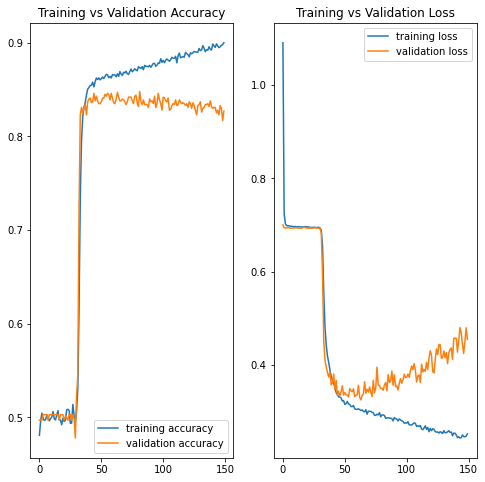

In [58]:
epochs=150
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label="training accuracy")
plt.plot(range(epochs),val_acc,label="validation accuracy")
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label="training loss")
plt.plot(range(epochs), val_loss, label="validation loss")
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [61]:
file = "Chat_bot_epochs_150.h5"
model.save(file)

## Evaluating given tests

In [63]:
model.load_weights(file)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 7ms/step


In [64]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [65]:
print(f"Story: {' '.join(train_data[0][0])} \nQuestion: {' '.join(train_data[0][1])} \nAnswer: {train_data[0][2]}")

Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . 
Question: Is Sandra in the hallway ? 
Answer: no


In [66]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  1.0


## Writing your own stories and questions

In [67]:
#We can only use the words from following vocab
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [93]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [94]:
my_question = "Is John in the kitchen ?"
my_question.split()

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [95]:
mydata = [(my_story.split(),my_question.split(),'no')]

In [96]:
my_story, my_q, ans = vectorize_stories(mydata)

In [97]:
pred_results = model.predict(([ my_story, my_q]))

1/1 [==============================] - 0s 35ms/step


In [98]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99999857
